In [5]:
import sys
sys.path.append('../../matminer/')

In [13]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from pymatgen.core import Structure
from pymatgen.analysis.magnetism.analyzer import CollinearMagneticStructureAnalyzer
from pymatgen.analysis.magnetism.jahnteller import JahnTellerAnalyzer

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold,KFold


from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import r2_score,roc_auc_score,accuracy_score

import numpy as np
from tqdm.auto import tqdm

In [6]:
import  matminer.featurizers.structure as st
import matminer.featurizers.site  as site

from matminer.featurizers.conversions import StrToComposition

from matminer.featurizers.base import MultipleFeaturizer

from pymatgen.analysis.local_env import VoronoiNN


In [10]:
import pandas as pd
df=pd.read_json('../structure-Tc-dataset/Tc_dataset_all.json')


In [11]:
df_mp=df.dropna(subset='mpids')
df_aflow=df.dropna(subset='auid')
df_oqmd=df.dropna(subset='oqmd_id')

In [14]:
df['structures']=[Structure.from_dict(x) for x in df_mp['structures'].to_list()]\
    +[Structure.from_str(x,fmt='cif') for x in df_aflow['structures'].to_list()]\
        +[Structure.from_file('../poscars/POSCAR_'+str(int(x))) for x in df_oqmd['oqmd_id'].to_list()]

df['high_Tc']=df['Tc'].apply(lambda x:1 if x>300 else 0)

In [15]:
df

,structures,compounds,mpids,Tc,auid,oqmd_id,icsd_id,high_Tc
0,[[-1.58789162e-03 7.75677710e-03 1.92917204e...,Ce3(AgGe)4,mp-640597,10.00,None,NaN,NaN,0
1,"[[-7.69363399 -1.5745392 -4.74483154] Pr, [-3...",Pr14Ag51,mp-1220249,13.00,None,NaN,NaN,0
2,"[[4.30161818 4.30161783 0.14833597] Ce, [4.303...",CeAl3Ag,mp-1226650,3.10,None,NaN,NaN,0
3,"[[4.30331507 4.3033151 0.13553857] Pr, [4.304...",PrAl3Ag,mp-1219803,5.80,None,NaN,NaN,0
4,"[[1.36881251 0.96789661 2.37085312] Cd, [4.106...",Cd2AgAu,mp-31170,310.00,None,NaN,NaN,1
...,...,...,...,...,...,...,...,...
1495,"[[5.719271 3.23625 0.570108] Ga, [2.269771 3....",GdGaNi,None,29.25,None,2026792.0,634227.0,0
1496,"[[0. 0. 0.406215] Ga, [2.129127 1....",PrGaGe,None,19.40,None,1983292.0,NaN,0
1497,"[[2.88409 1.167452 0.369578] Gd, [2.286548 3....",Gd3Rh2,None,51.00,None,1800200.0,NaN,0
1498,"[[ 1.043416 -2.083708 -1.040292] Gd, [-1.04341...",Gd5Sb3,None,260.00,None,30412.0,636366.0,0


In [11]:

# df['ferro_structures']=[CollinearMagneticStructureAnalyzer(x,overwrite_magmom_mode='replace_all')\
#     .get_ferromagnetic_structure(make_primitive=True) for x in df['structures'].to_list()]
# df['mag_struct_class']=[CollinearMagneticStructureAnalyzer(x,overwrite_magmom_mode='replace_all') for x in df['structures'].to_list()]


In [12]:
# for idx,row in df.iterrows():
#     eig_values=np.linalg.eig(row['ferro_structures'].distance_matrix).eigenvalues
#     eig_values=eig_values.real
#     len_arr=eig_values.size
    
#     if len_arr>15:
#         len_arr=15
#         eig_values=eig_values[:15]
    
#     df.loc[idx,['species_'+str(i) for i in range(len_arr)]]=eig_values
    
    

In [13]:
# for idx,row in df.iterrows():
#     # mag_only_struct=row['mag_struct_class'].get_structure_with_only_magnetic_atoms()
    

#     for j,mag_species in enumerate(row['ferro_structures'].get_all_neighbors(r=4.0)):
#         distances=[]
#         main_site=row['ferro_structures'].sites[j]
#         for k,neighbor in enumerate(mag_species):
            
#             dist=main_site.distance(neighbor)
#             distances.append(dist)
    
#         arr=np.array(distances)
#         arr=arr[arr!=0]
#         if arr.size!=0:
            
#             uniques=np.unique(arr)
#             df.at[idx,'species_'+str(j+1)+'_'+'std']=np.std(uniques)
#             df.at[idx,'species_'+str(j+1)+'_'+'max']=np.max(uniques)
#             df.at[idx,'species_'+str(j+1)+'_'+'min']=np.min(uniques)
#             df.at[idx,'species_'+str(j+1)+'_'+'ave']=np.average(uniques)
        
#         if j==14:
#             break
        
    
    
    
    

In [14]:
# df['num_mag_sites']=[x.number_of_magnetic_sites for x in df['mag_struct_class'].to_list()]
# df['num_uniq_mag_sites']=[x.number_of_unique_magnetic_sites() for x in df['mag_struct_class'].to_list()]
# df['num_nonuniq_mag_sites']=df['num_mag_sites']-df['num_uniq_mag_sites']

# df['num_uniq_mag_sites']=df['num_uniq_mag_sites']/df['num_mag_sites']
# df['num_nonuniq_mag_sites']=df['num_nonuniq_mag_sites']/df['num_mag_sites']
# df['magmom_density']=[sum(x.magmoms)/y.volume for x,y in zip(df['mag_struct_class'].to_list(),df['structures'].to_list())]


In [15]:


featurizers=MultipleFeaturizer(
    [
        # st.SiteStatsFingerprint.from_preset('ucar_local_prop_diff'),  #1;  1+2=0.632
        # st.SiteStatsFingerprint.from_preset('ucar_elemental_prop'), #2
        # st.SiteStatsFingerprint(site.BondOrientationalParameter()), #3,  1+2+3=0.637
        #st.SiteStatsFingerprint(site.AverageBondLength(method=VoronoiNN(),)) #4 #1+2+4=0.637
        #st.SiteStatsFingerprint(site.AverageBondAngle(method=VoronoiNN(),)) #5, #1+2+4=0.633
        
        
        st.SiteStatsFingerprint(site.AGNIFingerprints()), #6  alone =0.653, 1+2+6=0.637..
        st.SiteStatsFingerprint(site.OPSiteFingerprint()), #7, along=0.643  6+7=0.661
        # st.SiteStatsFingerprint(site.VoronoiFingerprint()), #10 alone =0.66, 6+7+10=0.67, 1+2+6+7+10=0.65
        st.OrbitalFieldMatrix(), #18, 0.635 , 6+7+10+18=0.677 after dropping 0 values in columns with .any()



        # st.SiteStatsFingerprint(site.CrystalNNFingerprint.from_preset('ops')), #8 alone =0.64 , 6+7+8=0.655
        #st.SiteStatsFingerprint(site.CrystalNNFingerprint.from_preset('cn')), #9 alone =0.627
        # st.SiteStatsFingerprint(site.IntersticeDistribution()) #11, 0.642, 6+7+10+11=0.675
        #st.SiteStatsFingerprint(site.GaussianSymmFunc()), #12 alone= 0.626
        #st.BondFractions.from_preset('VoronoiNN'), #12, 0.622
        #st.BagofBonds(), #13 took very long
        # st.StructuralHeterogeneity(), #14, 0.627, 6+7+10+14=0.659
        #st.MinimumRelativeDistances(), #15, 0.614
        
        #st.CoulombMatrix() #16, 0.62
        #st.SineCoulombMatrix(), #17, 0.634
        #st.XRDPowderPattern(), #19, 0.638, 6+7+10+19=0.663
        # st.RadialDistributionFunction() #20, 0.643, 6+7+10+20=0.666


        # st.GlobalSymmetryFeatures(),
        # st.DensityFeatures(),
        # st.ChemicalOrdering(),    #ALL basic ones= 0.652
        # st.MaximumPackingEfficiency(),
        # st.StructuralComplexity()
    ]
)

In [16]:
# df=featurizers.fit_featurize_dataframe(df,col_id='structures',ignore_errors=True)

In [17]:
# df.columns.to_list()[:10]

In [18]:
# df=df.loc[:,df.any()]

In [19]:
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# splits=skf.split(df, df['high_Tc'])
    
# maes = []
# r2s=[]  
# for train_index,test_index in splits:
#     train,test=df.loc[train_index],df.loc[test_index]
#     train_features=train.drop(columns=['structures', 'compounds', 'mpids', 'Tc', 'auid', 'oqmd_id', 'icsd_id','high_Tc'])
#     test_features=test.drop(columns=['structures', 'compounds', 'mpids', 'Tc', 'auid', 'oqmd_id', 'icsd_id','high_Tc'])
    
#     train_target=train['Tc']
#     test_target=test['Tc']

#     random_regressor = RandomForestRegressor(
#     n_estimators=200, max_depth = 30, n_jobs=-1, random_state=0)
#     random_regressor.fit(train_features, train_target)
#     predictions = random_regressor.predict(test_features)
#     mae = mean_absolute_error(list(test_target), predictions)
#     r2=r2_score(list(test_target), predictions)
#     print('mae %.3f' % mae)
#     print('r2: %.3f' % r2)
    
#     maes.append(mae)
#     r2s.append(r2)

In [20]:
# np.mean(maes)

In [21]:
X=featurizers.featurize_many(df['structures'],ignore_errors=True)

MultipleFeaturizer:   1%|▏         | 20/1500 [00:00<00:12, 114.64it/s]/Users/huseyin.ucar/anaconda3/envs/matgl/lib/python3.9/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/huseyin.ucar/anaconda3/envs/matgl/lib/python3.9/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/huseyin.ucar/anaconda3/envs/matgl/lib/python3.9/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/huseyin.ucar/anaconda3/envs/matgl/lib/python3.9/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use

In [23]:
X = np.array(X)
print('Input data shape:', X.shape)

Input data shape: (1500, 1162)


In [24]:

import pandas as pd
failed = np.any(pd.isnull(X), axis=1)
print('Number failed: {}/{}'.format(np.sum(failed), len(failed)))

Number failed: 0/1500


In [23]:
model = Pipeline([
    ('imputer', SimpleImputer()), # For the failed structures
    ('model', RandomForestRegressor(n_estimators=200, max_depth = 20, n_jobs=-1, random_state=0))
])

In [26]:

accs = []
rocs=[]
progress_bar = tqdm(range(10))

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

splits=skf.split(df, df['high_Tc'])

maes=[]
r2s=[]
for train_ids, test_ids in splits:
    # Split off the datasets
    train_X = X[train_ids, :]
    train_y = df['Tc'].iloc[train_ids]
    test_X = X[test_ids, :]
    test_y = df['Tc'].iloc[test_ids]
    
    # Train the model
    model.fit(train_X, train_y)
    
    # Run the model, compute MAE
    predict_y = model.predict(test_X)
    mae = mean_absolute_error(list(test_y), predict_y)
    r2=r2_score(list(test_y), predict_y)
    print('mae %.3f' % mae)
    print('r2: %.3f' % r2)
    
    maes.append(mae)
    r2s.append(r2)



  0%|          | 0/10 [00:00<?, ?it/s]

mae 64.362
r2: 0.811
mae 85.005
r2: 0.761
mae 72.760
r2: 0.802
mae 81.788
r2: 0.710
mae 74.417
r2: 0.783
mae 72.972
r2: 0.788
mae 82.932
r2: 0.763
mae 73.663
r2: 0.768
mae 71.319
r2: 0.735
mae 76.708
r2: 0.786


In [33]:
np.mean(maes)

75.59246240799781

In [64]:
np.mean(r2s)

0.7706435425482528

In [29]:
X.dump(open('matminer_features_Tc.npy', 'wb'))


In [8]:
import numpy as np
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold,KFold
Tc_features = np.load(open('matminer_features_Tc.npy', 'rb'),allow_pickle=True)


In [24]:

accs = []
rocs=[]
progress_bar = tqdm(range(10))

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

splits=skf.split(df, df['high_Tc'])

maes=[]
r2s=[]
for train_ids, test_ids in splits:
    # Split off the datasets
    train_X = Tc_features[train_ids, :]
    train_y = df['Tc'].iloc[train_ids]
    test_X = Tc_features[test_ids, :]
    test_y = df['Tc'].iloc[test_ids]
    
    # Train the model
    model.fit(train_X, train_y)
    
    # Run the model, compute MAE
    predict_y = model.predict(test_X)
    mae = mean_absolute_error(list(test_y), predict_y)
    r2=r2_score(list(test_y), predict_y)
    print('mae %.3f' % mae)
    print('r2: %.3f' % r2)
    
    maes.append(mae)
    r2s.append(r2)

  0%|          | 0/10 [02:36<?, ?it/s]


mae 64.391
r2: 0.811
mae 84.944
r2: 0.761
mae 72.611
r2: 0.803
mae 81.803
r2: 0.709
mae 74.384
r2: 0.784
mae 72.992
r2: 0.787
mae 82.802
r2: 0.764
mae 73.643
r2: 0.768
mae 71.259
r2: 0.735
mae 76.746
r2: 0.786


In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Set global font properties
plt.rcParams.update({
    'font.family': 'Arial',
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'axes.titlesize': 36,
    'axes.labelsize': 36,
    'legend.fontsize': 36,
})
%matplotlib inline
%config InlineBackend.figure_format ='retina'

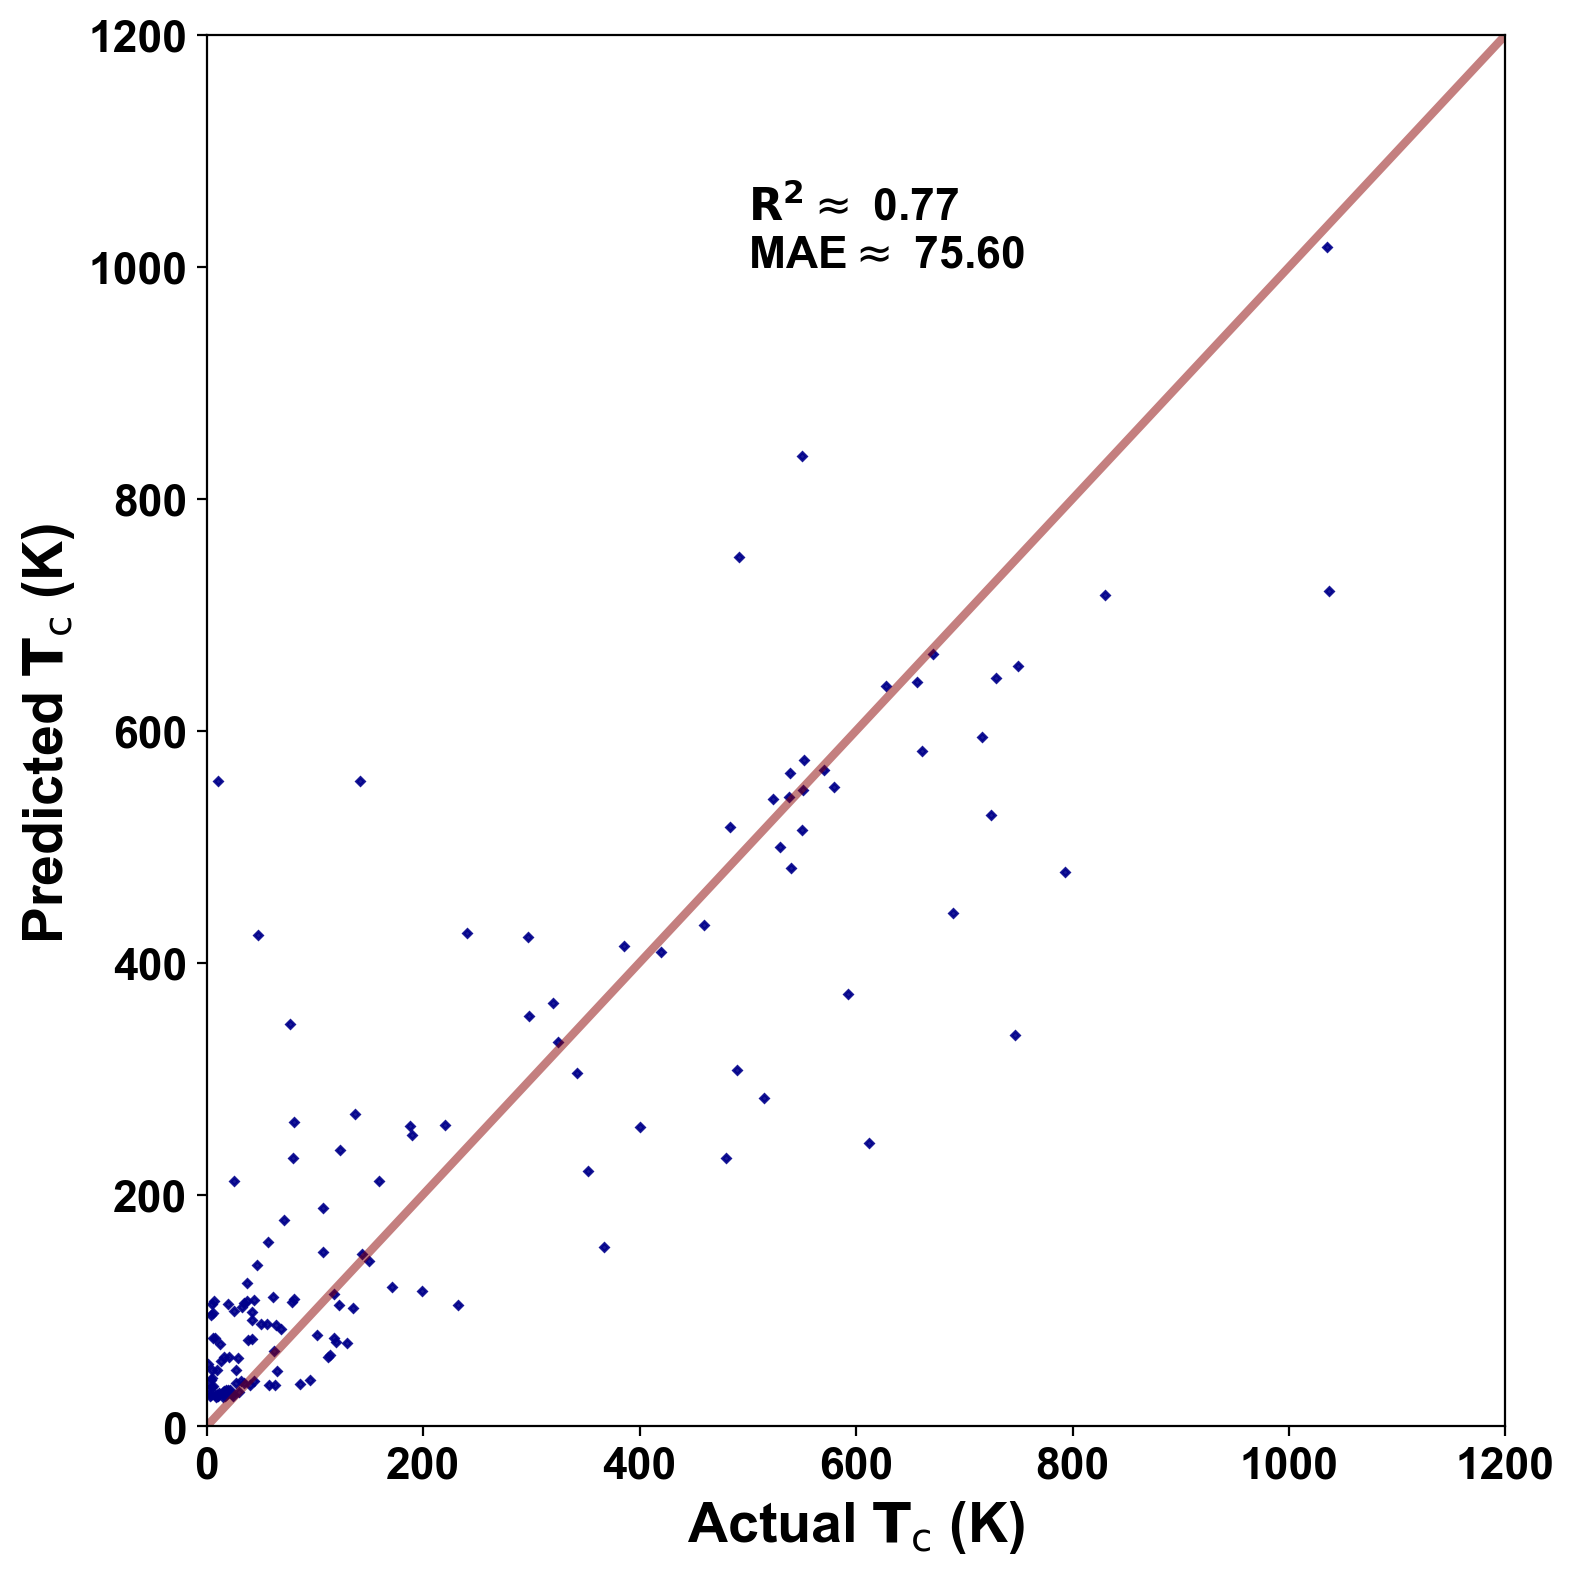

In [34]:
ts=16
ts2=16
ms=7
ms2=6
lg_font = 17

plt.rcParams['figure.figsize'] = (8.0, 8.0)
fig = plt.figure()
p1, = plt.plot(test_y, predict_y, 
         'D', color = "DarkBlue", ms = 2, alpha = 0.9)
plt.plot([1, 1200], [1, 1200],color = "DarkRed", lw = 3, alpha = 0.5)

plt.xlabel('Actual $\mathbf{T_{\mathrm{c}}}$ (K)', fontsize=20) #r'$T_{\mathrm{c}}$ (K)'

plt.ylabel('Predicted $\mathbf{T_{\mathrm{c}}}$ (K) ', fontsize=20)

plt.text(500, 1000, r'$\mathbf{R^2}$$\approx$ 0.77' "\n" r'MAE$\approx$ 75.60', fontsize=16)

plt.ylim(-0, 1200)
plt.xlim(-0, 1200)
plt.xticks(fontsize = ts)
plt.yticks(fontsize = ts)
plt.tight_layout()

plt.savefig('Parity plot results of Tc_model.png', dpi=300, bbox_inches='tight')


In [19]:
import joblib
# joblib.dump(model, "/home/huseyin.ucar/matminer/2-train-Tc/Tc_RF.joblib")

In [21]:
model=joblib.load("./Tc_RF.joblib")

In [22]:
model.predict(np.array(featurizers.featurize(df['structures'][1400])).reshape(1,-1))

NameError: name 'featurizers' is not defined

In [28]:
model

Pipeline(steps=[('imputer', SimpleImputer()),
                ('model',
                 RandomForestRegressor(max_depth=20, n_estimators=200,
                                       n_jobs=-1, random_state=0))])